In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlock_ffhq import UN
from BinomDataset_ffhq_inpaint import BinomDataset
from DataFolderFFHQ import DataFolder
from inference_ffhq import sample_image
from tasks import inpainting
from utils import preprocess, stats

In [2]:
name = 'm40to30-256x256-ffhq'
# name = 'm40to30-256x256-ffhq-run-2'
CHECKPOINT_PATH = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/checkpoints/models/'

model = UN(channels = 3, levels=10, depth=6,start_filts=32, 
           up_mode = 'upsample', merge_mode = 'concat').to(device)
model = UN.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

In [3]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/faces/'
minpsnr = -40
maxpsnr = 30
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1)

In [4]:
# img[:channels].max()

(-0.5, 255.5, 255.5, -0.5)

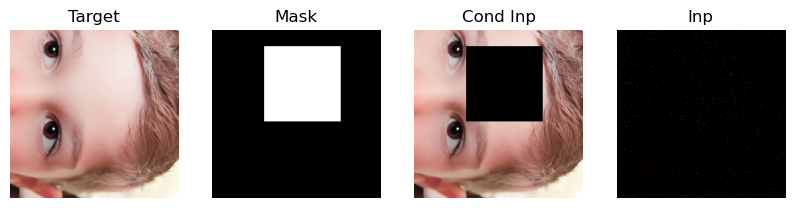

In [5]:
channels = 3
img = dataset[5000000000]
plt.figure(figsize= (10, 10))
plt.subplot(1, 4, 1)
plt.imshow(preprocess(img[:channels]), vmin = 0, vmax = np.percentile(img[:channels].permute(1, 2, 0), 99.9))
plt.title('Target')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(preprocess(img[channels:channels + 1]), vmin = 0, vmax = 1, cmap= 'gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(preprocess(img[channels + 1:channels  + 1 + channels]), vmin = 0, vmax = 255)
plt.title('Cond Inp')
plt.axis('off')
plt.subplot(1, 4, 4)
# plt.imshow(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0))
plt.imshow(preprocess(img[channels  + 1 + channels:channels  + 1 + channels + channels]), vmin = 0, vmax = 255)
plt.title('Inp')
plt.axis('off')
# stats(img[:channels].permute(1, 2, 0)), stats(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)), 

(-0.5, 511.5, 511.5, -0.5)

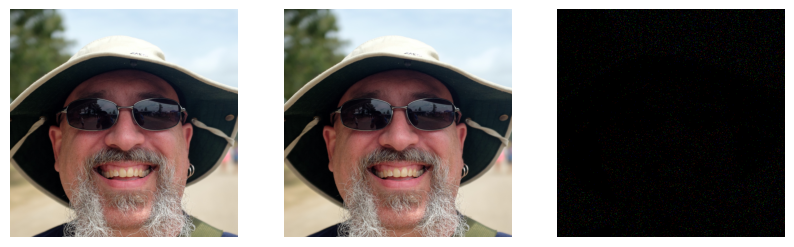

In [54]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
dataset = DataFolder(ffhq_path, minPSNR = -30, maxPSNR= 0, virtSize= 1)
dataTestGT, dataTestTarget, dataTest = dataset[0]
# dataTestGT, dataTestTarget, dataTest = dataTestGT/dataTestGT.max(), dataTestTarget/dataTestTarget.max(), dataTest/dataTest.max()
plt.figure(figsize= (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(preprocess(dataTestGT), vmin = 0, vmax = 255)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(preprocess(dataTestTarget), vmin = 0, vmax = 1, cmap= 'gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(preprocess(dataTest), vmin = 0, vmax = 255)
plt.axis('off')


torch.Size([3, 512, 512])


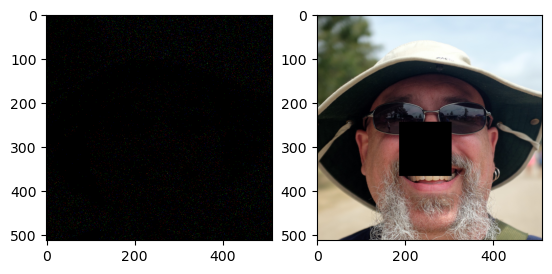

In [60]:
masks = inpainting(imgsize = 512, masksize = 100)
mask = masks.generate_mask().numpy()
test = dataTest 
testGT = dataTestGT/dataTestGT.mean()
cond_test = testGT * (1 - mask)
print(cond_test.shape)
plt.subplot(1, 2, 1)
plt.imshow(preprocess(test),)
plt.subplot(1, 2, 2)
plt.imshow(preprocess(cond_test))

In [8]:
test.name == None

True

In [9]:
stats(test), stats(cond_test)


Shape : torch.Size([3, 512, 512])

Min : 0.0

Max : 2.0

Sum : 5013.0

Mean : 0.006374359130859375


Shape : torch.Size([3, 512, 512])

Min : 0.0

Max : 2.2479476928710938

Sum : 647880.3125

Mean : 0.8238224387168884



(None, None)

torch.Size([3, 512, 512])
torch.Size([1, 4, 512, 512])
torch.Size([3, 512, 512])
input shape : torch.Size([1, 7, 512, 512]), model input shape : torch.Size([1, 1, 7, 512, 512])
tensor(255.) tensor(0.) tensor(81.8422) 255.0 110.0
inp shape : torch.Size([3, 512, 512])
out shape : torch.Size([1, 3, 512, 512])
gt shape : torch.Size([3, 512, 512])


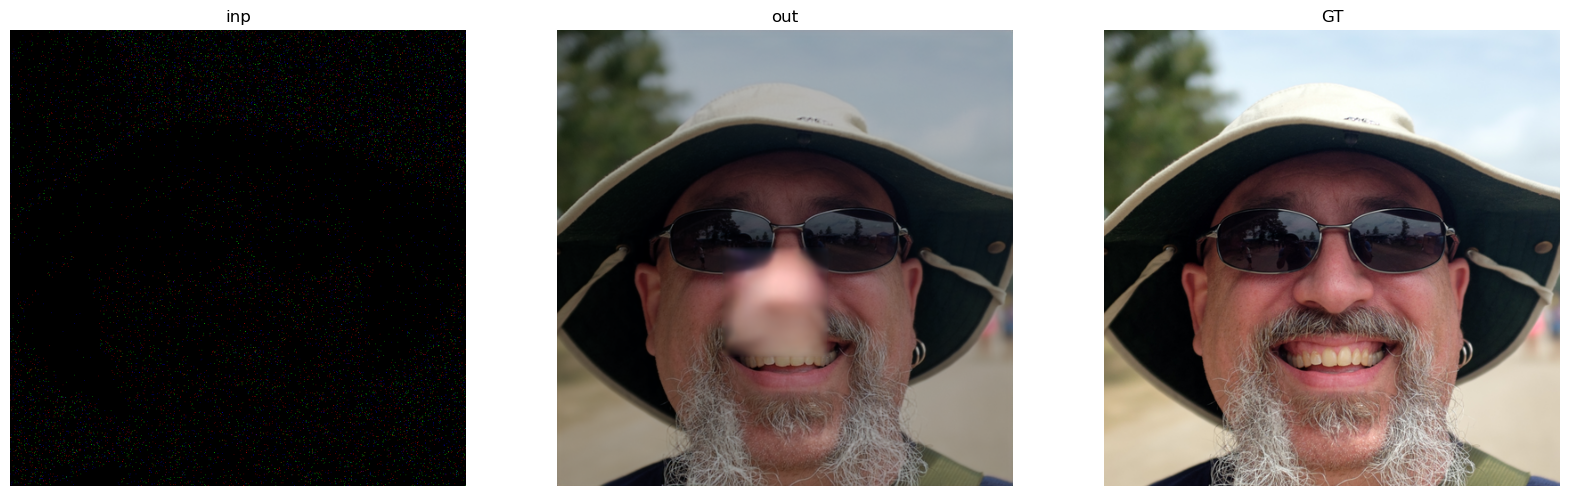

In [61]:
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))

for inp, cinp, gt in zip(dataTest[None], cond_input[None], dataTestGT[None]): 
    print(inp.shape) 
    print(cinp.shape) 
    print(gt.shape) 

    inpT = (inp).to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inpT[None]], dim = 1).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    y = model(inpT).detach().cpu()
    out = np.exp(y)

    out = inp.sum() * out / out.sum() 
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    # inp = inp/inp.max()
    # out = out/out.max()
    # gt = gt/gt.max()
    # cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    # cond_vmax = np.percentile(cond_inp,99.9)
    plt.figure(figsize=(20,20))
    # plt.subplot(1, 3, 1)
    # plt.imshow(cond_inp ,vmin = 0, vmax = cond_vmax)
    # plt.title('cond_inp')
    # plt.axis('off')

    vmax = np.percentile(preprocess(gt),99.9)
    plt.subplot(1, 3, 1)
    plt.imshow(preprocess(inp),vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(preprocess(out[0]),vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(preprocess(gt),vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    


In [11]:
stats(gt, cond_test)


Shape : torch.Size([3, 512, 512])

Min : 0.0

Max : 2.2479476928710938

Sum : 786432.0625

Mean : 1.0000001192092896


Shape : torch.Size([3, 512, 512])

Min : 0.0

Max : 2.2479476928710938

Sum : 647880.3125

Mean : 0.8238224387168884



In [12]:
from inference_ffhq import sample_image

cond_input shape torch.Size([1, 4, 512, 512])
cond_img shape torch.Size([1, 4, 512, 512])
input_img shape torch.Size([1, 7, 512, 512])
input_img shape torch.float32
Iteration : 1
Iteration : 2
Iteration : 3
Iteration : 4
Iteration : 5
Iteration : 6
Iteration : 7
Iteration : 8
Iteration : 9
Iteration : 10
Iteration : 11
Iteration : 12
Iteration : 13
Iteration : 14
Iteration : 15
Iteration : 16
Iteration : 17
Iteration : 18
Iteration : 19
Iteration : 20
Iteration : 21
Iteration : 22
Iteration : 23
Iteration : 24
Iteration : 25
Iteration : 26
Iteration : 27
Iteration : 28
Iteration : 29
Iteration : 30
Iteration : 31
Iteration : 32
Iteration : 33
Iteration : 34
Iteration : 35
Iteration : 36
Iteration : 37
Iteration : 38
Iteration : 39
Iteration : 40
Iteration : 41
Iteration : 42
Iteration : 43
Iteration : 44
Iteration : 45
Iteration : 46
Iteration : 47
Iteration : 48
Iteration : 49
Iteration : 50
Iteration : 51
Iteration : 52
Iteration : 53
Iteration : 54
Iteration : 55
Iteration : 56
Iter

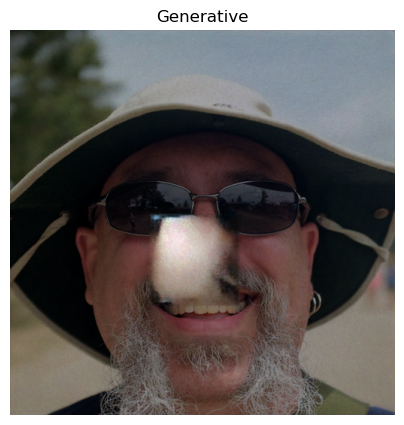

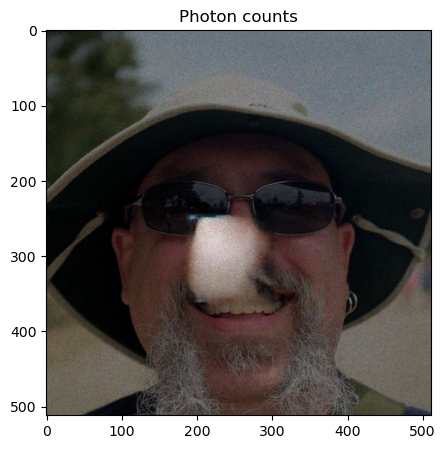

_______________________________________ 356
time (s): 17.901427745819092 time per image (s) 17.901427745819092


In [62]:
import matplotlib.image as mpimg
import time
import numpy as np

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 3
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 512
pixels_y = 512

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x)
# inp_img = test[None]
# masks2 = inpainting(imgsize = 512, masksize = 500)
# mask = masks2.generate_mask().numpy()
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))
print(f'cond_input shape {cond_input.shape}')

cond_img = cond_input
print(f'cond_img shape {cond_img.shape}')

# cond_img = torch.zeros_like(cond_img)
input_img = torch.cat((cond_img, inp_img), 1).to(device)
print(f'input_img shape {input_img.shape}')
print(f'input_img shape {input_img.dtype}')


for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    denoised, photons, stack, iterations = sample_image(input_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = 20,
                                                        max_its = 5000,
                                                        channels = 3)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
#         print(iterations)
            # print(denoised.shape)
            # plt.figure(figsize = (5,5))
            # plt.imshow(denoised[j].transpose(1, 2, 0), cmap='inferno', vmin = 0,
            #            vmax = np.percentile(denoised[j],99.99))
            # plt.title('Generative')
            # plt.axis('off')
            # plt.show()
            
            # plt.figure(figsize = (5,5))
            # plt.imshow(photons[j,0], cmap='inferno', vmin = 0,
            #            vmax = np.percentile(photons[j],99.99))
            # plt.title('Photon counts')
            # plt.show()
            denoised/=denoised.mean()
            print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(preprocess(denoised[0]), vmin = 0,
                       vmax = np.percentile(preprocess(denoised[0]),99.99))
            plt.title('Generative')
            plt.axis('off')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(preprocess(photons[0]), vmin = 0,
                       vmax = np.percentile(preprocess(photons[0]),99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    
    
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print ('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])
   

0


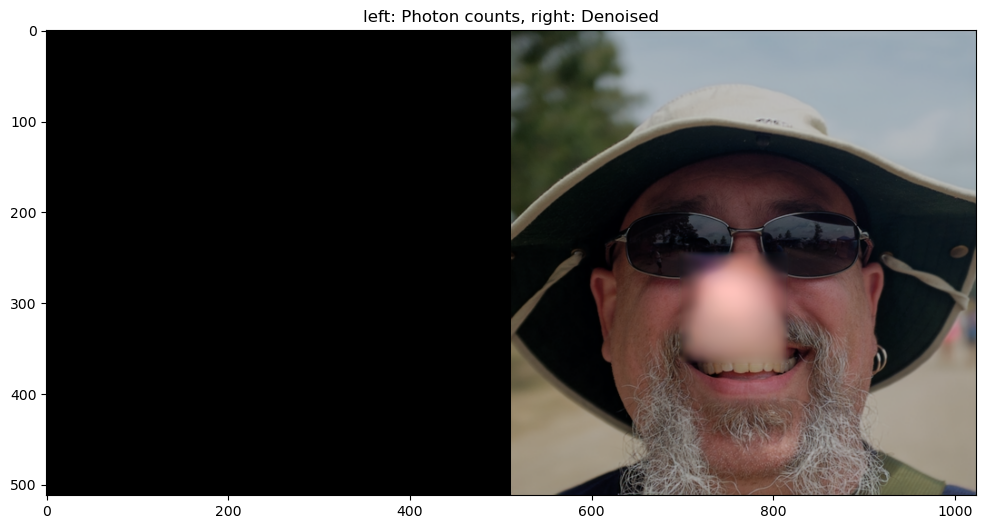

10


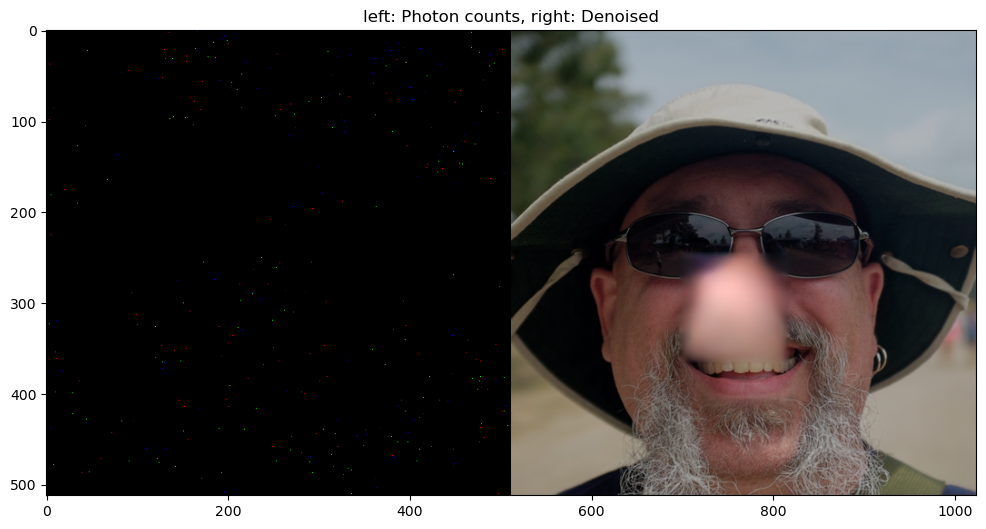

20


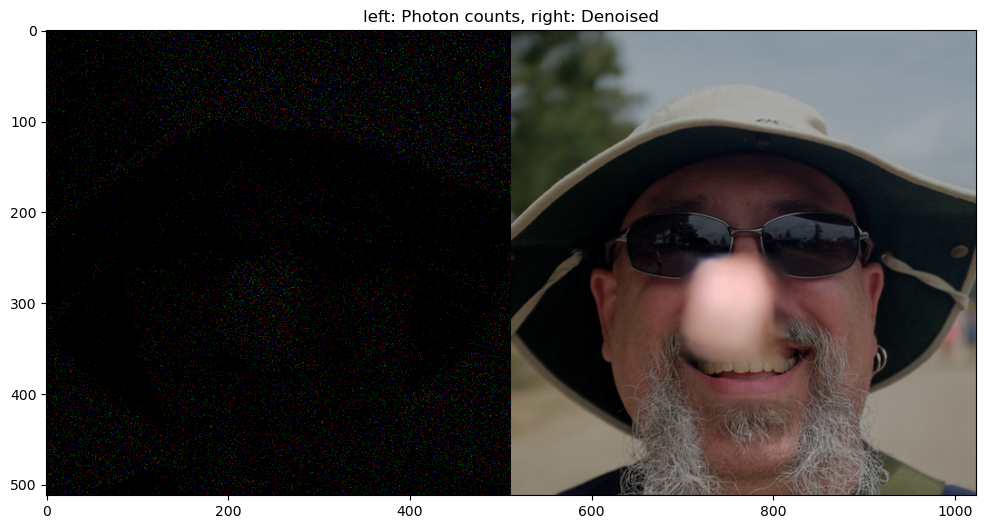

30


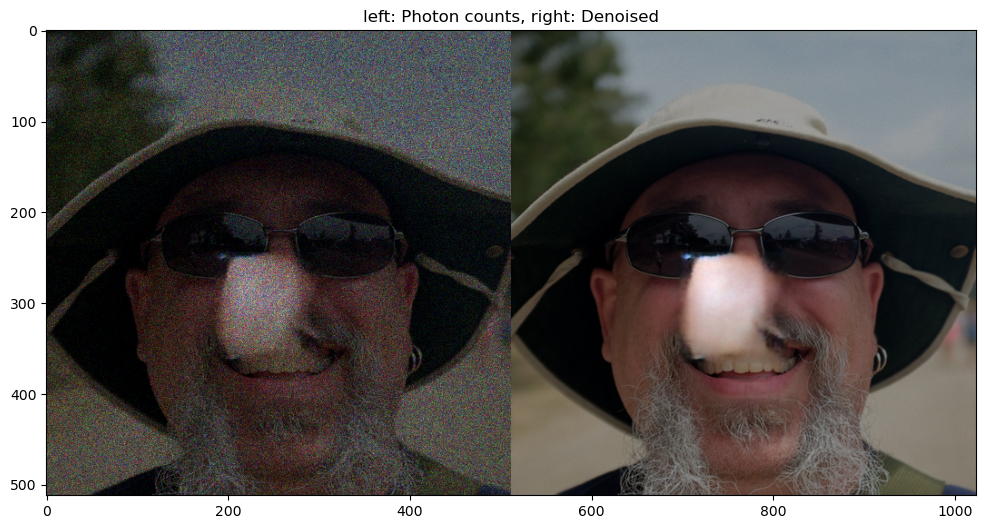

In [63]:
stack[0].shape
for i in range(len(stack)):
    if i%10 == 0 :
        im = (stack[i].transpose(1, 2, 0) * 255).astype(np.uint8)
        print(i)
        plt.figure(figsize = (12,12))
        plt.imshow(im, vmax = 0.9)
        plt.title('left: Photon counts, right: Denoised')
        plt.show()

In [48]:
len(stack)

34

In [46]:
import cv2

def stack_video(stack, filename, framerate):
    _, H, W = stack[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' or 'mp4v' for .avi and .mp4 formats respectively
    out = cv2.VideoWriter(filename, fourcc, framerate, (W, H))
    for frame in stack:
        out.write(cv2.cvtColor((frame.transpose(1, 2, 0) * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    out.release()
    print(f'Video saved at {filename}')

In [49]:
file_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/outputs/stack-videos/'
file_name = 'first.mp4'
stack_video(stack= stack, 
            filename= os.path.join(file_path, file_name),
            framerate = 2)

Video saved at /mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/outputs/stack-videos/first.mp4


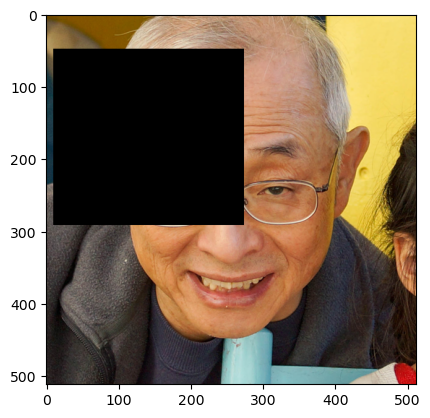

In [42]:
plt.imshow(cond_test.permute(1, 2, 0)/cond_test.permute(1, 2, 0).max())

(torch.Size([3, 512, 512]), tensor(1.), tensor(0.0001), tensor(102.))

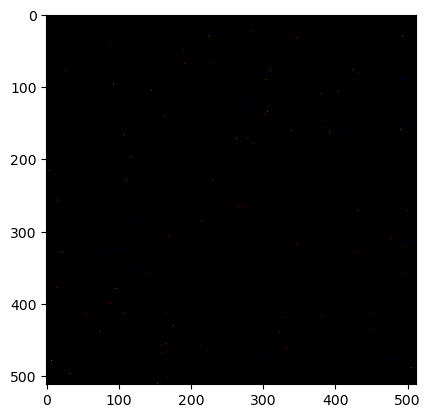

In [111]:
out2 = y[0]

img = torch.poisson((torch.exp(out2 - out2.max())/(torch.exp(out2 - out2.max()).sum())) * 100)
plt.imshow(img.permute(1, 2, 0))
img.shape, img.max(), img.mean(), img.sum()

(torch.Size([3, 512, 512]), tensor(1.), tensor(0.0001), tensor(96.))

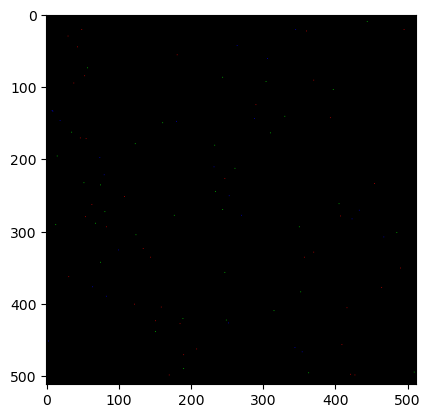

In [99]:
out3 = y[0]

img = torch.poisson((torch.exp(out2)/(torch.exp(out3).sum())) * 100)
plt.imshow(img.permute(1, 2, 0))
img.shape, img.max(), img.mean(), img.sum()

In [60]:
torch.poisson(out[0]).shape, torch.poisson(out[0]).max(), torch.poisson(out[0]).mean()

(torch.Size([3, 512, 512]), tensor(7.), tensor(0.3899))

torch.Size([3, 512, 512])
torch.Size([1, 4, 512, 512])
torch.Size([3, 512, 512])
input shape : torch.Size([1, 7, 512, 512]), model input shape : torch.Size([1, 1, 7, 512, 512])
tensor(255.) tensor(0.) tensor(65.2451) 252.0 110.0
inp shape : torch.Size([3, 512, 512])
out shape : torch.Size([1, 3, 512, 512])
gt shape : torch.Size([3, 512, 512])


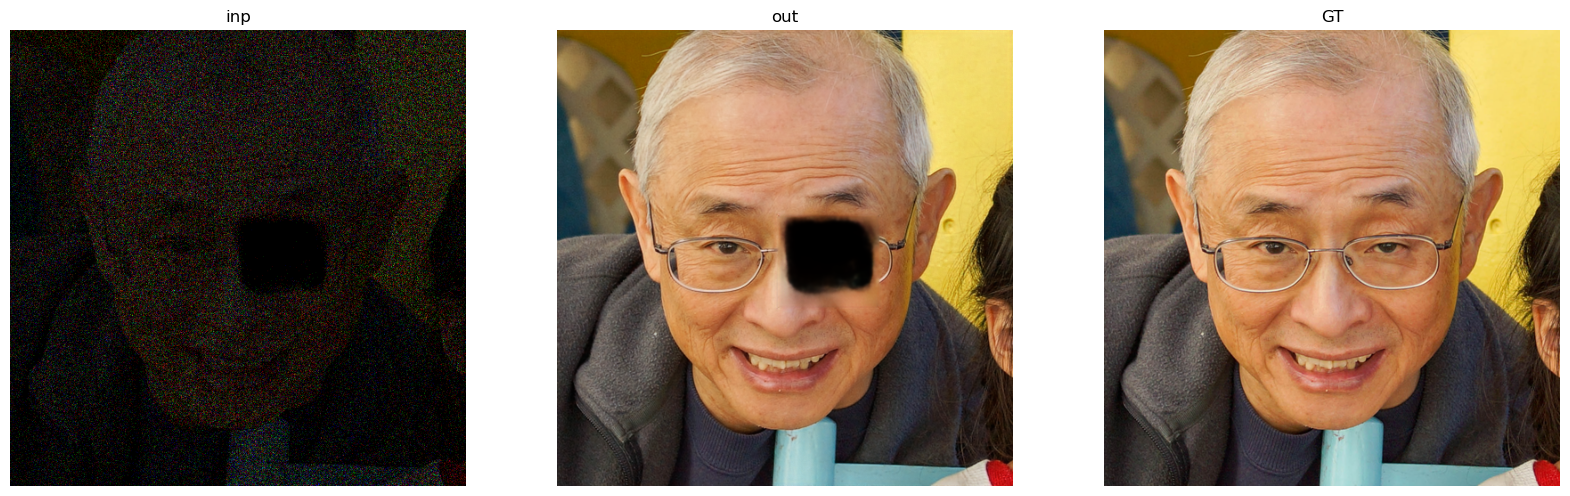

In [124]:
cond_input = torch.from_numpy(np.expand_dims(np.concatenate((mask, cond_test), axis = 0), axis = 0))
# dataTest = img.clone()
dataTest = torch.poisson(out[0])
for inp, cinp, gt in zip(dataTest[None], cond_input[None], dataTestGT[None]): 
    print(inp.shape) 
    print(cinp.shape) 
    print(gt.shape) 

    inpT = inp.to(device) 
    cond_inpT = cinp.to(device)
    inpT = torch.cat([cond_inpT, inpT[None]], dim = 1).to(device)
    print(f'input shape : {inpT.shape}, model input shape : {inpT[None].shape}')
    out = torch.exp(model(inpT).detach().cpu())
    out = inp.sum() * out / out.sum() 
    
    print(gt.max(), gt.min(), gt.std(), np.percentile(gt,99.9), np.percentile(gt,50))

    inp = inp/inp.mean()
    out = out/out.mean()
    gt = gt/gt.mean()
    inp = inp/inp.max()
    out = out/out.max()
    gt = gt/gt.max()
    # cond_inp = cinp[1]/cinp[1].mean()

    
    print(f'inp shape : {inp.shape}')
    print(f'out shape : {out.shape}')
    print(f'gt shape : {gt.shape}')

    # cond_vmax = np.percentile(cond_inp,99.9)
    plt.figure(figsize=(20,20))
    # plt.subplot(1, 3, 1)
    # plt.imshow(cond_inp ,vmin = 0, vmax = cond_vmax)
    # plt.title('cond_inp')
    # plt.axis('off')

    vmax = np.percentile(gt,99.9)
    plt.subplot(1, 3, 1)
    plt.imshow(inp.permute(1, 2, 0),vmin = 0, vmax = vmax)
    plt.title('inp')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(out[0].permute(1, 2, 0),vmin = 0,vmax = vmax)
    plt.title('out')
    # plt.show()
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(gt.permute(1, 2, 0),vmin = 0,vmax = vmax)
    plt.title('GT')
    plt.axis('off')
    plt.show()
    
